In [1]:
!pip -q install kaggle

In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d salader/dogsvscats

Dataset URL: https://www.kaggle.com/datasets/salader/dogsvscats
License(s): unknown
 98% 1.04G/1.06G [00:07<00:00, 160MB/s]
100% 1.06G/1.06G [00:07<00:00, 154MB/s]


In [18]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogsvscats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [20]:
# generators
# use batch wise images, very useful to process large datasets
# we will use keras generators

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256) # this will reshape all the images to 256x256 as all images are not of same shape
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256) # this will reshape all the images to 256x256 as all images are not of same shape
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [21]:
# Normalize images between 0 to 1

def process(image, label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [22]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size = (3,3),padding = 'valid',activation = 'relu',input_shape = (256,256,3)))
model.add(BatchNormalization()) # to reduce overfitting
model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = 'valid'))

model.add(Conv2D(64,kernel_size = (3,3),padding = 'valid',activation = 'relu'))
model.add(BatchNormalization()) # to reduce overfitting
model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = 'valid'))

model.add(Conv2D(128,kernel_size = (3,3),padding = 'valid',activation = 'relu'))
model.add(BatchNormalization()) # to reduce overfitting
model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = 'valid'))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [26]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 90ms/step - accuracy: 0.5727 - loss: 2.3315 - val_accuracy: 0.5350 - val_loss: 0.9617
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 87ms/step - accuracy: 0.6901 - loss: 0.5841 - val_accuracy: 0.7680 - val_loss: 0.4897
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.7663 - loss: 0.4849 - val_accuracy: 0.7952 - val_loss: 0.4628
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.8047 - loss: 0.4282 - val_accuracy: 0.7834 - val_loss: 0.4653
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - accuracy: 0.8336 - loss: 0.3713 - val_accuracy: 0.7442 - val_loss: 0.5642
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8678 - loss: 0.3049 - val_accuracy: 0.5496 - val_loss: 1.8751
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8981 - loss: 0.2478 - val_accuracy: 0.7902 - val_loss: 0.4679
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.9290 - loss: 0.1743 - 

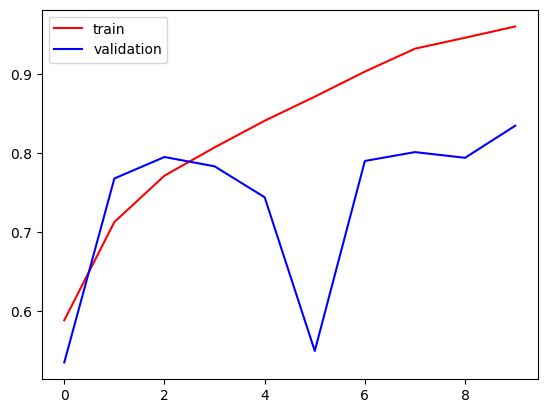

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

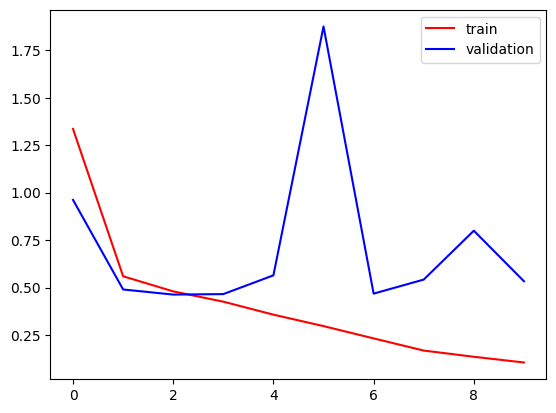

In [28]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [25]:

# overfitting happen

# ways to reduce overfitting

#add more data
# Data Augmentation
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

In [26]:
# testing on different image

In [29]:
import cv2

In [38]:
test_image = cv2.imread('/content/dog.jpg')

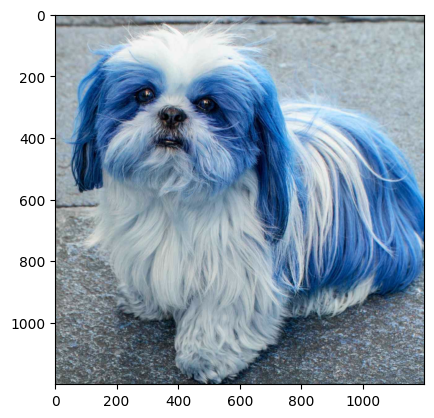

In [39]:
plt.imshow(test_image)

In [40]:
test_image.shape

(1200, 1200, 3)

In [41]:
test_img = cv2.resize(test_image,(256,256))

In [42]:
test_input = test_img.reshape((1,256,256,3))

In [43]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[1.]], dtype=float32)

In [ ]:
## data augmentation

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
img = image.load_img('/content/train_aug/cat.jpg',target_size=(256,256))


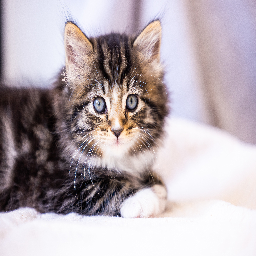

In [5]:
img

In [14]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest' # while shifting populate nearby pixels with neighbouring pixels
)# many other features are also there

In [7]:
img = image.img_to_array(img)

In [8]:
type(img)

numpy.ndarray

In [9]:
img.shape

(256, 256, 3)

In [10]:
input_batch = img.reshape(1,256,256,3)

In [15]:
i=0

for output in datagen.flow(input_batch,batch_size=1,save_to_dir='/content/aug_images'):
  i=i+1

  if i==10:
    break


In [13]:
input_batch.shape

(1, 256, 256, 3)

In [44]:
## applying data augmentation on entire directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [45]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

#this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in folders

train_generator = train_datagen.flow_from_directory(
    '/content/train', # this is the target directory
    target_size=(256,256), # all images will be resize to 256x256
    batch_size=batch_size,
    class_mode='binary' # since we use binary_crossentropy loss, we need binary labels
)

# this is a similar generator for validation data
validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(256,256),
    batch_size=batch_size,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [47]:
## building model again

# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size = (3,3),padding = 'valid',activation = 'relu',input_shape = (256,256,3)))
model.add(BatchNormalization()) # to reduce overfitting
model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = 'valid'))

model.add(Conv2D(64,kernel_size = (3,3),padding = 'valid',activation = 'relu'))
model.add(BatchNormalization()) # to reduce overfitting
model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = 'valid'))

model.add(Conv2D(128,kernel_size = (3,3),padding = 'valid',activation = 'relu'))
model.add(BatchNormalization()) # to reduce overfitting
model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = 'valid'))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [49]:
model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [53]:

history = model.fit(
    train_generator,
    steps_per_epoch = 2000//batch_size,
    epochs = 25,
    validation_data = validation_generator,
    validation_steps = 800//batch_size
)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.7476 - loss: 0.5737 - val_accuracy: 0.6725 - val_loss: 0.5918
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.7264 - loss: 0.5969 - val_accuracy: 0.7437 - val_loss: 0.4887
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.7543 - loss: 0.5260 - val_accuracy: 0.7462 - val_loss: 0.5403
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 255ms/step - accuracy: 0.7486 - loss: 0.5850 - val_accuracy: 0.7887 - val_loss: 0.4820
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.7474 - loss: 0.5484 - val_accuracy: 0.6550 - val_loss: 0.6452
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step - accuracy: 0.7716 - loss: 0.5291 - val_accuracy: 0.7500 - val_loss: 0.5061
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - accuracy: 0.7933 - loss: 0.4636 - val_accuracy: 0.6237 - val_loss: 0.6687
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.8018 - loss: 0

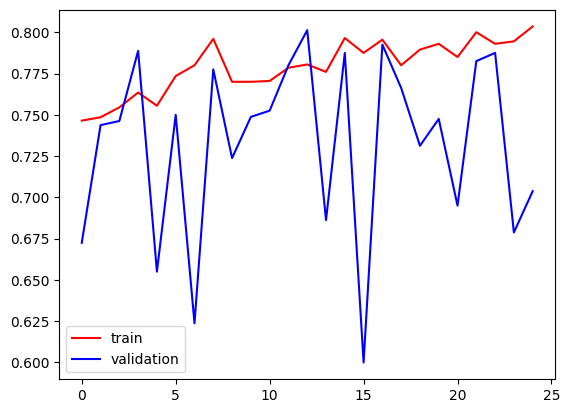

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

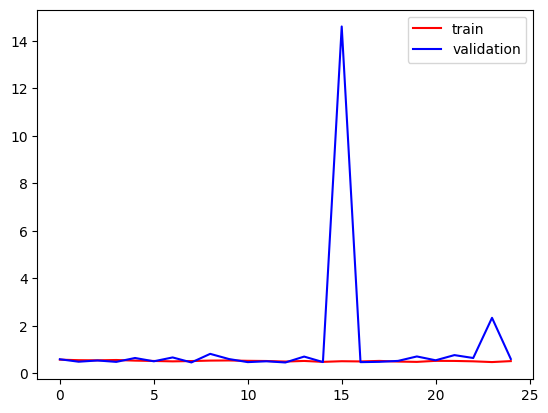

In [55]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()